<a href="https://colab.research.google.com/github/estheroratemstet/CreditRisk/blob/main/estheroratemstet/CreditRisk/main/PATCH/Universal_Attack_CIFAR10_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universal Attack CIFAR10

In this notebook we are implementing targeted and untargeted attack of the Stochastic Gradient Descent (SGD) algorithm for generating Universal Adversarial Perturbations (UAPs).

UAP is a kind of adversarial attacks on deep neural networks where a single UAP can fool a model on an entire set of affected inputs.<br>
SGD has been shown to create more effective UAPs than the originally iterative-DeepFool.


We are going to attack images from CIFAR10 dataset.<br>
Model Accuracy is: 87%<br>
We are going to do a targeted and untargeted attack:<br>
After the **untargeted** attack we see that:<br>
The accuracy after the attack is 25%<br>
After the **targeted** attack we see that:<br>
The accuracy after the attack is 33%<br>



This notebook is mainly based on https://github.com/kenny-co/sgd-uap-torch/blob/main/notebooks/cifar10_attack.ipynb


##Prequisites

In [2]:
import os
import sys
import math
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CIFAR10 Model

In [6]:
class Target(nn.Module):
    def __init__(self):
        super(Target, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3,96,3), # 96*30*30
            nn.GroupNorm(32, 96),
            nn.ELU(),
            
            nn.Dropout2d(0.2),
            
            nn.Conv2d(96, 96, 3), # 96*28*28
            nn.GroupNorm(32, 96),
            nn.ELU(),
            
            nn.Conv2d(96, 96, 3), # 96*26*26
            nn.GroupNorm(32, 96),
            nn.ELU(),
            
            nn.Dropout2d(0.5),
            
            nn.Conv2d(96, 192, 3), # 192*24*24
            nn.GroupNorm(32, 192),
            nn.ELU(),
            
            nn.Conv2d(192, 192, 3), # 192*22*22
            nn.GroupNorm(32, 192),
            nn.ELU(),
           
            nn.Dropout2d(0.5),
            
            nn.Conv2d(192, 256, 3), # 256*20*20
            nn.GroupNorm(32, 256),
            nn.ELU(),
            
            nn.Conv2d(256, 256, 1), # 256*20*20
            nn.GroupNorm(32, 256),
            nn.ELU(),
            
            nn.Conv2d(256, 10, 1), # 10*20*20
            nn.AvgPool2d(20) # 10*1*1
        )

    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1,10)

        return out

Function for: 
- Loading cifar dataset
- Evaluating on dataset with or without UAP

In [4]:

# dataloader for CIFAR-10
def loader_cifar(dir_data, train = False, batch_size = 250):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    if train:
        trainset = torchvision.datasets.CIFAR10(root = dir_data, train = True, download = True, transform = transform_test)
        dataloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = max(1, multiprocessing.cpu_count() - 1))
    else:
        testset = torchvision.datasets.CIFAR10(root = dir_data, train = False, download = True, transform = transform_test)
        dataloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = max(1, multiprocessing.cpu_count() - 1))
    return dataloader


# Evaluate model on data with or without UAP
# Assumes data range is bounded by [0, 1]
def evaluate(model, loader, uap = None, n = 5):
    '''
    OUTPUT
    top         top n predicted labels (default n = 5)
    top_probs   top n probabilities (default n = 5)
    top1acc     array of true/false if true label is in top 1 prediction
    top5acc     array of true/false if true label is in top 5 prediction
    outputs     output labels
    labels      true labels
    '''
    probs, labels = [], []
    model.eval()
    
    if uap is not None:
        _, (x_val, y_val) = next(enumerate(loader))
        batch_size = len(x_val)
        uap = uap.unsqueeze(0).repeat([batch_size, 1, 1, 1])
    
    with torch.set_grad_enabled(False):
        for i, (x_val, y_val) in enumerate(loader):
            
            if uap is None:
                out = torch.nn.functional.softmax(model(x_val), dim = 1)
            else:
                perturbed = torch.clamp((x_val + uap), 0, 1) # clamp to [0, 1]
                out = torch.nn.functional.softmax(model(perturbed), dim = 1)
                
            probs.append(out.cpu().numpy())
            labels.append(y_val)
            
    # Convert batches to single numpy arrays    
    probs = np.stack([p for l in probs for p in l])
    labels = np.array([t for l in labels for t in l])
    # Extract top 5 predictions for each example
    top = np.argpartition(-probs, n, axis = 1)[:,:n]
    top_probs = probs[np.arange(probs.shape[0])[:, None], top].astype(np.float16)
    top1acc = top[range(len(top)), np.argmax(top_probs, axis = 1)] == labels
    top5acc = [labels[i] in row for i, row in enumerate(top)]
    outputs = top[range(len(top)), np.argmax(top_probs, axis = 1)]
        
    return top, top_probs, top1acc, top5acc, outputs, labels

### Load data

In [7]:
# LOAD DATA

dir_data = '/data/cifar10'
dir_uap = '../uaps/cifar10/'

trainloader = loader_cifar(dir_data = dir_data, train = True)
testloader = loader_cifar(dir_data = dir_data, train = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar10/cifar-10-python.tar.gz to /data/cifar10
Files already downloaded and verified


### Load model

In [8]:
model = Target()
model.load_state_dict(torch.load("/content/drive/MyDrive/models/target.pth",map_location=torch.device('cpu')))

<All keys matched successfully>

### Accuracy before attack 87%

In [9]:
_, _, _, _, outputs, labels = evaluate(model, testloader)
print("Outputs: ",outputs)
print("Labels: ",labels)
print('Accuracy: %.2f %%' % (100 * float(sum(outputs == labels) ) / len(labels)))

Outputs:  [0 8 7 ... 5 6 8]
Labels:  [0 8 7 ... 5 6 8]
Accuracy: 87.26 %


### Load & Predict A Random Image

In [10]:
for images, labels in testloader:
    images = images
    labels=labels

In [86]:
# you can choose any number between 0-250 to predict an image
ind=np.random.randint(250) 

True Label:  tensor([6])
Predict:  tensor([6])


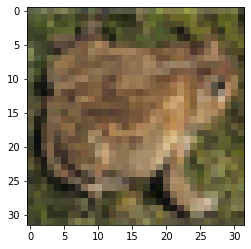

In [87]:
img=images[ind:ind+1] 
outputs = model(img)
_, predicted = torch.max(outputs.data, 1)
img=img.reshape(3,32,32)
print("True Label: " ,labels[ind:ind+1])
print("Predict: ", predicted)
plt.imshow(img.permute(1, 2, 0))

## UAP 

In [13]:
'''
Basic version of untargeted stochastic gradient descent UAP adapted from:
[AAAI 2020] Universal Adversarial Training
- https://ojs.aaai.org//index.php/AAAI/article/view/6017

Layer maximization attack from:
Universal Adversarial Perturbations to Understand Robustness of Texture vs. Shape-biased Training
- https://arxiv.org/abs/1911.10364
'''
def uap_sgd(model, loader, nb_epoch, eps, beta = 12, step_decay = 0.8, y_target = None, loss_fn = None, layer_name = None, uap_init = None):
    '''
    INPUT
    model       model
    loader      dataloader
    nb_epoch    number of optimization epochs
    eps         maximum perturbation value (L-infinity) norm
    beta        clamping value
    y_target    target class label for Targeted UAP variation
    loss_fn     custom loss function (default is CrossEntropyLoss)
    layer_name  target layer name for layer maximization attack
    uap_init    custom perturbation to start from (default is random vector with pixel values {-eps, eps})
    
    OUTPUT
    delta.data  adversarial perturbation
    losses      losses per iteration
    '''
    

# לכל תמונה מגדירים רעש ואז שולחים את התמונה והרעש לאופטימזציה

    _, (x_val, y_val) = next(enumerate(loader))
    batch_size = len(x_val)
    if uap_init is None:
        batch_delta = torch.zeros_like(x_val) # initialize as zero vector
    else:
        batch_delta = uap_init.unsqueeze(0).repeat([batch_size, 1, 1, 1])
    delta = batch_delta[0]
    losses = []
    
    # loss function
    if layer_name is None:
        if loss_fn is None: loss_fn = nn.CrossEntropyLoss(reduction = 'none') # define the loss function
        beta = torch.FloatTensor([beta])
        # This function will calculate the average of losses by minimizing to know what the loss is
        def clamped_loss(output, target): 
            loss = torch.mean(torch.min(loss_fn(output, target), beta)) #מימיזציה על ההפסד  בטא= פרמטר של רגוליזציה  - עושה ממוצע של הטעויות
            return loss
       
    # layer maximization attack
    else:
        def get_norm(self, forward_input, forward_output):
            global main_value
            main_value = torch.norm(forward_output, p = 'fro')
        for name, layer in model.named_modules():
            if name == layer_name:
                handle = layer.register_forward_hook(get_norm)
    # makes it so that autograd will begin to record operations on tensor.            
    batch_delta.requires_grad_()

    for epoch in range(nb_epoch):
        print('epoch %i/%i' % (epoch + 1, nb_epoch))
        
        # perturbation step size with decay
        eps_step = eps * step_decay # קצב הדעיכה 
        for i, (x_val, y_val) in enumerate(loader): 
          
            batch_delta.data.zero_()
            batch_delta.data = delta.unsqueeze(0).repeat([x_val.shape[0], 1, 1, 1]) 

            # for targeted UAP, switch output labels to y_target
            if y_target is not None: y_val = torch.ones(size = y_val.shape, dtype = y_val.dtype) * y_target # מכוון ל y_target 

            perturbed = torch.clamp((x_val + batch_delta), 0, 1)
            outputs = model(perturbed)
            
            # loss function value
            if layer_name is None: loss = clamped_loss(outputs, y_val)
            else: loss = main_value
            
            # אופטחמיזציה שונה
            if y_target is not None: loss = -loss # minimize loss for targeted UAP
            losses.append(torch.mean(loss))
            loss.backward()
            
            # batch update
            # מוסיף את הרעש של התמונה לרעש הכללי 

            grad_sign = batch_delta.grad.data.mean(dim = 0).sign() # ממוצע הרעש
            delta = delta + grad_sign * eps_step
            delta = torch.clamp(delta, -eps, eps)
            batch_delta.grad.data.zero_()
    
    if layer_name is not None: handle.remove() # release hook
    
    return delta.data, losses

### Untergeted UAP 

In [190]:
nb_epoch = 1
eps = 10 / 255
beta = 10
uap, losses = uap_sgd(model, testloader, nb_epoch, eps, beta)

epoch 1/1


Display Pertubation Image

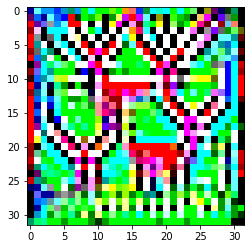

In [191]:
per1=np.transpose(((uap / eps) + 1) / 2, (1, 2, 0))
plt.imshow(per1)

#### predict image attack
We can see that the predict label of the image with the pertubation is not the same of the predict label of the image without the prtubation.

label  tensor(6)
pred  tensor([6])


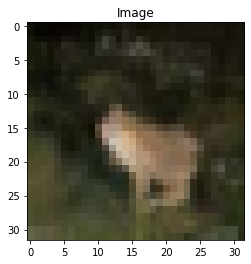

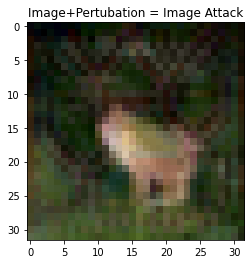

predict after attack  tensor([4])


In [193]:
ind=0
with torch.set_grad_enabled(False):
  for i, (x_val, y_val) in enumerate(testloader):
        x=x_val[ind].reshape(1,3,32,32)
        y=y_val[ind]
print("label " , y)
out=model(x)
_, predicted = torch.max(out.data, 1)
print("pred ",predicted)

x2=x[0,:,:,:]
plt.title('Image')
plt.imshow(x2.permute(1,2,0))
plt.show()


perturbed = torch.clamp((x + uap), 0, 1) # clamp to [0, 1]
x_p2=perturbed[0,:,:,:]
plt.title('Image+Pertubation = Image Attack')
plt.imshow(x_p2.permute(1,2,0))
plt.show()
out2 = torch.nn.functional.softmax(model(perturbed), dim = 1)
_, predicted2 = torch.max(out2.data, 1)
print("predict after attack ",predicted2)

#### Accuracy after untargeted attack 25%

In [194]:
# evaluate
_, _, _, _, outputs, labels = evaluate(model, testloader, uap = uap)
print('Accuracy:', sum(outputs == labels) / len(labels))

Accuracy: 0.2512


#### Plotting

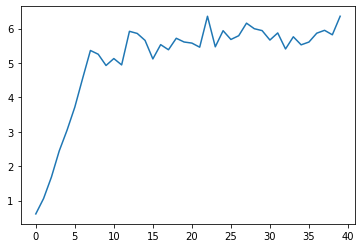

In [195]:
losses2=[]
for i in range(len(losses)):
  losses2.append(losses[i].item())
plt.plot(losses2)

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

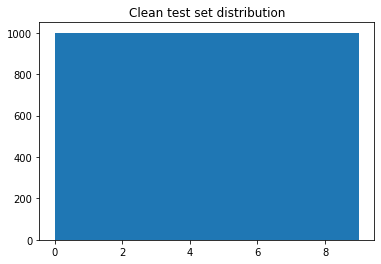

In [196]:
# plot histogram
plt.title('Clean test set distribution')
plt.hist(labels)

(array([  92.,  512.,   92.,   21., 8309.,   58.,  181.,  203.,  145.,
         387.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

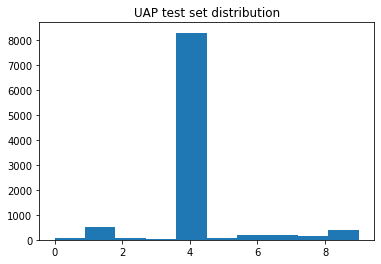

In [197]:
# plot histogram
plt.title('UAP test set distribution')
plt.hist(outputs)

### Targeted UAP 
y_target=7

In [17]:
nb_epoch = 10
eps = 10 / 255
y_target = 7
beta = 10
uap, losses = uap_sgd(model, testloader, nb_epoch, eps, beta, y_target = y_target)

epoch 1/10
epoch 2/10
epoch 3/10
epoch 4/10
epoch 5/10
epoch 6/10
epoch 7/10
epoch 8/10
epoch 9/10
epoch 10/10


Display Pertubation Image

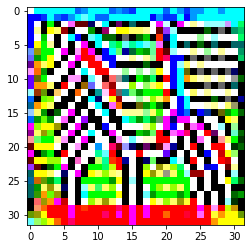

In [101]:
# visualize UAP
per7=np.transpose(((uap / eps) + 1) / 2, (1, 2, 0))
plt.imshow(per7)

#### predict image attack
We can see that the predict label of the image with the pertubation is equal to the target label that we declared.

label  tensor(0)
pred  tensor([0])


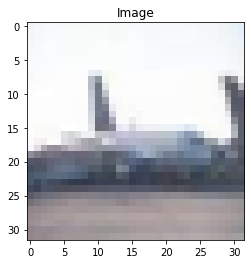

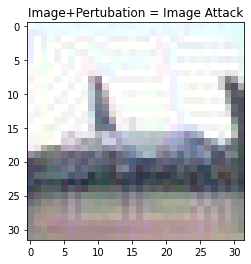

predict after attack  tensor([7])


In [189]:
ind=0
with torch.set_grad_enabled(False):
  for i, (x_val, y_val) in enumerate(testloader):
        x=x_val[ind].reshape(1,3,32,32)
        y=y_val[ind]
print("label " , y)
out=model(x)
_, predicted = torch.max(out.data, 1)
print("pred ",predicted)

x2=x[0,:,:,:]
plt.title('Image')
plt.imshow(x2.permute(1,2,0))
plt.show()


perturbed = torch.clamp((x + uap), 0, 1) # clamp to [0, 1]
x_p2=perturbed[0,:,:,:]
plt.title('Image+Pertubation = Image Attack')
plt.imshow(x_p2.permute(1,2,0))
plt.show()
out2 = torch.nn.functional.softmax(model(perturbed), dim = 1)
_, predicted2 = torch.max(out2.data, 1)
print("predict after attack ",predicted2)

#### Accuracy after target attack 33% and Targeted success rate: 73%

In [29]:
# evaluate
_, _, _, _, outputs, labels = evaluate(model, testloader, uap = uap)
print('Accuracy:', sum(outputs == labels) / len(labels))
print('Targeted success rate:', sum(outputs == y_target) / len(labels))

Accuracy: 0.323
Targeted success rate: 0.7301


#### Plotting

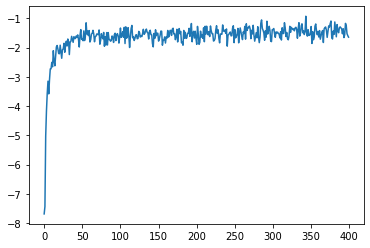

In [33]:
# plot loss
losses2=[]
for i in range(len(losses)):
  losses2.append(losses[i].item())
plt.plot(losses2)

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

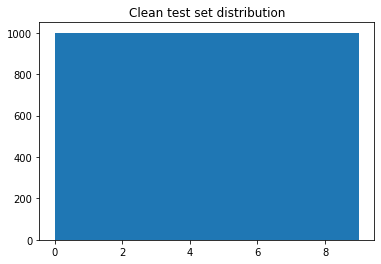

In [34]:
# plot histogram
plt.title('Clean test set distribution')
plt.hist(labels)

(array([ 182.,  502.,  314.,  105.,  218.,  159.,  412., 7301.,  191.,
         616.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

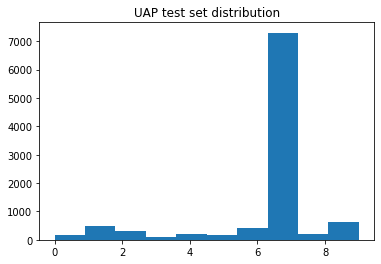

In [35]:
# plot histogram
plt.title('UAP test set distribution')
plt.hist(outputs)